In [1]:
# https://github.com/dariocazzani/pytorch-AE
# See tutorial on VAEs 

import os 
import sys

import functools
import itertools
from collections import defaultdict, namedtuple
from typing import List, Tuple, Union

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

BATCH_SIZE = 32
TEST_FRAC = .2

DEVICE='cuda'


In [2]:
class ChannelTransform(nn.Module):
    def __init__(self, max_channels: int, duplicate_single_channel: bool = True):
        super().__init__()
        self.channels = max_channels
        self.duplicate = duplicate_single_channel
        
    def forward(self, x):
        channels_to_add = self.channels - x.shape[0]
        if channels_to_add > 0:
            if self.duplicate:
                if x.shape[0] == 1: 
                    return torch.concat([x] * self.channels)
                else: 
                    raise ValueError(f"Input with shape {x.shape} does not have single channel to duplicate")
            else: 
                return torch.concat([x] + [torch.zeros(x.shape)] * channels_to_add)
        else: 
            return x

In [3]:
tensor = transforms.ToTensor()(np.eye(3))
add_channels = ChannelTransform(3)
add_channels(tensor).shape

torch.Size([3, 3, 3])

In [4]:
# Import data

# MNIST, FashionMNIST
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)
data_dim = train_data[0][0].shape

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

# img_transform = torch.nn.Sequential(
# #     transforms.CenterCrop(10),
# #     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# )
# img_transform = transforms.Compose([
#     transforms.Resize(size = (1000, 1000)), 
#     transforms.ToTensor(),
#     ChannelTransform(max_channels = 3, duplicate_single_channel = True)
# ])
# data = datasets.Caltech101(
#     root="data",
#     download=True,
#     transform=img_transform
# )
# n_data = len(data)
# n_test = int(n_data * TEST_FRAC)
# n_train = n_data - n_test
# train_data, test_data = torch.utils.data.random_split(data, [n_train, n_test])

# train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
# test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)
# # Need to preprocess so all the same size image. 

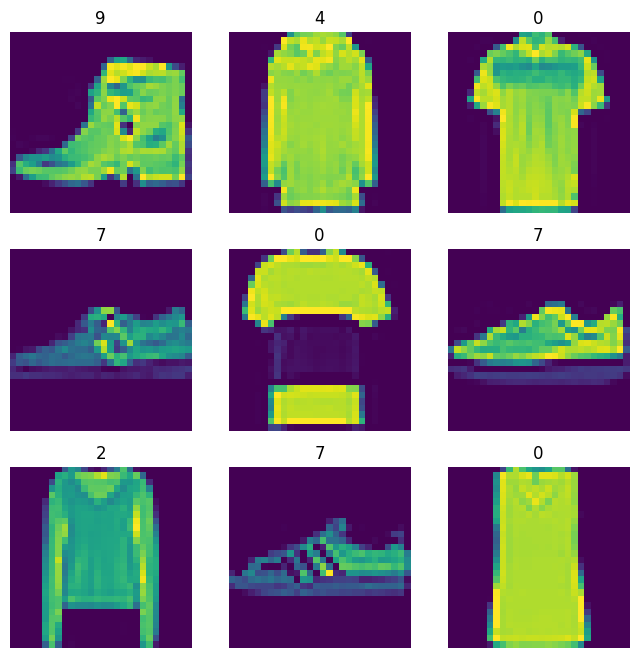

torch.Size([1, 28, 28])

In [5]:
# Inspect some data

# Fashion MNIST Labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    
    # RGB channels
    plt.title(label)
    plt.imshow(img.permute(1, 2, 0).squeeze())
    
    # Single Grayscale channel
#     plt.title(labels_map[label])
#     plt.imshow(img.squeeze(), cmap = "gray")

plt.show()

img.shape

In [6]:
# channels = []
# xs = []
# ys = []
# for img, _ in test_data: 
#     channel, x, y = img.shape
#     channels.append(channel)
#     xs.append(x)
#     ys.append(y)
    
# fig, axs = plt.subplots(ncols = 3)
# axs[0].hist(channels)
# axs[1].hist(xs)
# axs[2].hist(ys)
# fig.show()

In [7]:
class EncoderDecoder(nn.Module):
    def __init__(self): 
        super().__init__()
    
    def layer_inverse(self, layer: nn.Module) -> nn.Module: 
        if type(layer) is nn.Conv2d:
            new_layer = nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size,
                                           stride=layer.stride, output_padding=layer.padding)
        elif type(layer) == nn.ReLU: 
            new_layer = layer
        elif type(layer) is nn.Linear: 
            new_layer = nn.Linear(layer.out_features, layer.in_features, bias = layer.bias is not None)
        else: 
            raise ValueError(f"Layer type {type(layer)} inverse not supported")
        return new_layer

class ConvolutionalEncoder(EncoderDecoder):
    def __init__(self, in_channels, latent_variables, conv_layers = None, connected_layers = None):
        super().__init__()
        self.in_channels = in_channels
        self.latent_vars = latent_variables
        if conv_layers is None: 
            self.convolutions = nn.Sequential(
                nn.Conv2d(in_channels, 8, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=0),
                nn.ReLU(True)
            )
        else: 
            self.convolutions = nn.Sequential(*conv_layers)
        self.post_conv_size = (32, 3, 3)
#         self.post_conv_size = (32, 124, 124)
        self.flatten = nn.Flatten()
        
        # this 32 value is going to be problematic
        if connected_layers is None: 
            self.connected = nn.Sequential(
#                 nn.Linear(3 * 3 * 32, 128),
                nn.Linear(functools.reduce(lambda a, b: a * b, self.post_conv_size), 128),
                nn.ReLU(True),
                nn.Linear(128, latent_variables)
            )
        else: 
            self.connected = nn.Sequential(*connected_layers)
        
        
    def forward(self, x):
        x = self.convolutions(x)
        x = self.flatten(x)
        x = self.connected(x)
        #x = torch.sigmoid(x)
        return x

    def to_decoder(self) -> nn.Module:
        deconv_layers = []
        for conv in reversed(self.convolutions):
            deconv = self.layer_inverse(conv)
            if len(deconv_layers) != 0 or type(deconv) is not nn.ReLU:
                deconv_layers.append(deconv)
        connected_layers = []
        for layer in reversed(self.connected):
            new_layer = self.layer_inverse(layer)
            if len(connected_layers) != 0 or type(new_layer) is not nn.ReLU:
                connected_layers.append(new_layer)

        return ConvolutionalDecoder(out_channels = in_channels, latent_variables = self.latent_vars, 
                                    deconv_layers = deconv_layers, connected_layers = connected_layers)

            
            
            
            
class ConvolutionalDecoder(EncoderDecoder):
    def __init__(self, out_channels, latent_variables, deconv_layers = None, connected_layers = None):
        super().__init__()
        self.out_channels = out_channels
        self.latent_vars = latent_variables
        if deconv_layers is None: 
            self.deconvolutions = nn.Sequential(
                nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
#                 nn.ConvTranspose2d(8, out_channels, 3, stride=2, padding=0, output_padding=0)
                nn.ConvTranspose2d(8, out_channels, 3, stride=2, padding=1, output_padding=1)
            )
        else: 
            self.deconvolutions = nn.Sequential(*deconv_layers)
            
        # This does not (by definiton) reconstruct the original size tensor 
            
            
        self.post_conv_size = (32, 3, 3)
#         self.post_conv_size = (32, 124, 124)

        if connected_layers is None: 
            self.connected = nn.Sequential(
                nn.Linear(latent_variables, 128),
                nn.ReLU(True),
                nn.Linear(128, functools.reduce(lambda a, b: a * b, self.post_conv_size)),
#                 nn.ReLU(True)
            )
        else: 
            self.connected = nn.Sequential(*connected_layers)

        self.unflatten = nn.Unflatten(dim = 1, unflattened_size=self.post_conv_size)

        
        
    def forward(self, x):
        x = self.connected(x)
        x = self.unflatten(x)
        x = self.deconvolutions(x)
        return x

    def to_encoder(self) -> nn.Module:
        return None

    
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, channels, latent_variables):
        super().__init__()
        self.encoder = ConvolutionalEncoder(channels, latent_variables)
        self.decoder = ConvolutionalDecoder(channels, latent_variables)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Model Definition
NamedModel = namedtuple("NamedModel", ["name", "model"])
LR = .00025
models = []
optimizers = []
for latent in [5]:
    model = ConvolutionalAutoencoder(channels = data_dim[0], latent_variables = latent).to(DEVICE)
    models.append(NamedModel(f"Latent{latent}", model))
    optimizers.append(torch.optim.Adam(model.parameters(), lr=LR))
model_optims = dict(zip(models, optimizers))


epoch_losses = defaultdict(lambda: [])

Training Latent5
Epoch 9 (Final) Loss: 0.01972595416009426


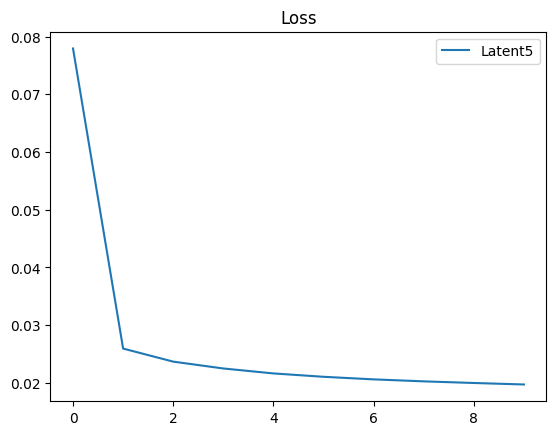

In [9]:
# Training Loop
loss_fn = nn.MSELoss()
epochs = 10
for namedmodel, optimizer in model_optims.items():
    name = namedmodel.name
    autoencoder = namedmodel.model 
    print(f"Training {name}")
    autoencoder.train()
    for epoch in range(epochs):
        batch_losses = []
        for img_batch, img_labels in train_dataloader:
            img_batch = img_batch.to(DEVICE)
            reconstructed = autoencoder(img_batch)
            loss = loss_fn(img_batch, reconstructed)

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.detach().cpu().numpy())
        mean_batch_loss = np.array(batch_losses).mean()
        epoch_losses[name].append(mean_batch_loss)
        if len(epoch_losses[name]) % 100 == 0: 
            print(f"Epoch {epoch} Loss: {mean_batch_loss}")
    print(f"Epoch {epoch} (Final) Loss: {mean_batch_loss}")
        
legend = []
for name, losses in epoch_losses.items():
    legend.append(name)
    plt.plot(losses)
plt.title("Loss")
plt.legend(legend)
plt.show()

In [10]:
# autoencoder = ConvolutionalAutoencoder(latent_variables = 2).to(DEVICE)
# print(autoencoder)

# autoencoder.encoder.to_decoder()


In [11]:
loss_fn = nn.MSELoss()
for namedmodel, optimizer in model_optims.items():
    name = namedmodel.name
    autoencoder = namedmodel.model
    autoencoder.eval()
    batch_losses = []
    for img_batch, img_labels in test_dataloader:
        img_batch = img_batch.to(DEVICE)
        reconstructed = autoencoder(img_batch)
        loss = loss_fn(img_batch, reconstructed)
        batch_losses.append(loss.detach().cpu().numpy())
    mean_batch_loss = np.array(batch_losses).mean()
    print(f"{name} test loss: {mean_batch_loss}")

Latent5 test loss: 0.01945517770946026


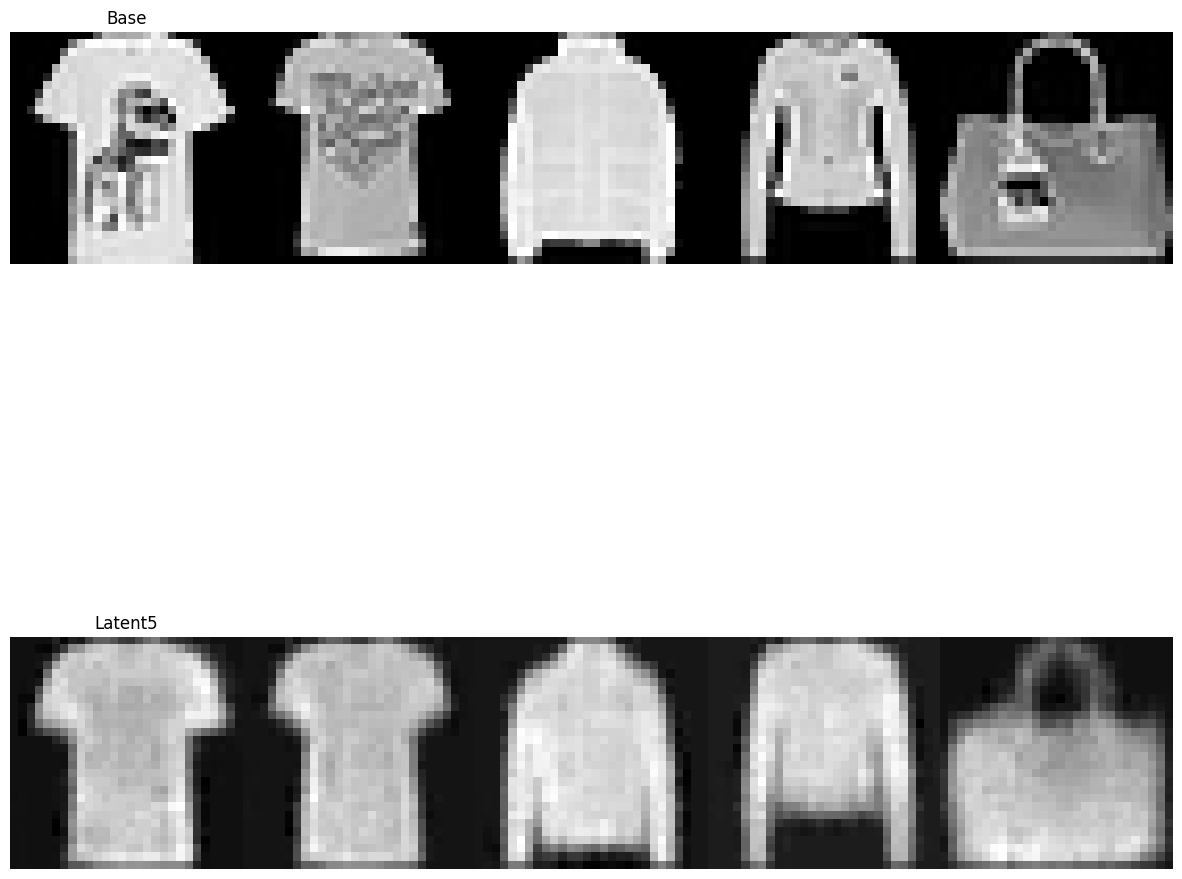

In [12]:
cols, rows = 5, len(models) + 1
fig, ax = plt.subplots(nrows = rows, ncols = cols)
fig.set_figheight(15)
fig.set_figwidth(15)
modelname_to_num = {namedmodel.name: i for i, namedmodel in enumerate(models)}
for i in range(0, cols):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    img = img.to(DEVICE).unsqueeze(0)
    modelname_to_img = {namedmodel.name: namedmodel.model(img) for namedmodel in models}
    img = img.detach().cpu().numpy()
    ax[0][i].imshow(img.squeeze(), cmap = "gray")
    ax[0][i].axis("off") 
    if(i == 0): 
        ax[0][i].title.set_text("Base")
    for modelname, reconstructed in modelname_to_img.items():
        reconstructed = reconstructed.detach().cpu().numpy()
        modelnum = modelname_to_num[modelname]
        cur_ax = ax[modelnum + 1][i]
        cur_ax.imshow(reconstructed.squeeze(), cmap = "gray")
        cur_ax.axis("off")
        if(i == 0): 
            cur_ax.title.set_text(modelname)
plt.subplots_adjust(wspace=0, hspace=.1)
plt.show()